Mounted at /content/drive
Dataset contains 1512 images across 15 classes.
Training set shape: (1058, 256, 256, 3), (1058, 15)
Validation set shape: (227, 256, 256, 3), (227, 15)
Test set shape: (227, 256, 256, 3), (227, 15)


<ipython-input-1-07667c8269a5>:65: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Number of unique categories: 15
Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.3991 - loss: 2.2656 - val_accuracy: 0.6564 - val_loss: 1.0304
Epoch 2/12
 1/33 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8750 - loss: 0.4040

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 447ms/step - accuracy: 0.8750 - loss: 0.4040 - val_accuracy: 0.6564 - val_loss: 0.9819
Epoch 3/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.8240 - loss: 0.4836 - val_accuracy: 0.8767 - val_loss: 0.3736
Epoch 4/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 491ms/step - accuracy: 0.9688 - loss: 0.1563 - val_accuracy: 0.8722 - val_loss: 0.3851
Epoch 5/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.8695 - loss: 0.3988 - val_accuracy: 0.8899 - val_loss: 0.3302
Epoch 6/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 641ms/step - accuracy: 0.9062 - loss: 0.2851 - val_accuracy: 0.8855 - val_loss: 0.3410
Epoch 7/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.9194 - loss: 0.2599 - val_accuracy: 0.8943 - val_loss: 0.2526
Epoch 8/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 612ms/step - accuracy: 0.9062 - loss: 0.2021 - val_accuracy: 0.8987 - val_loss: 0.2480
Epoch 9/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.9308 - loss: 0.2097 - val_accuracy: 0.9075 - val_l

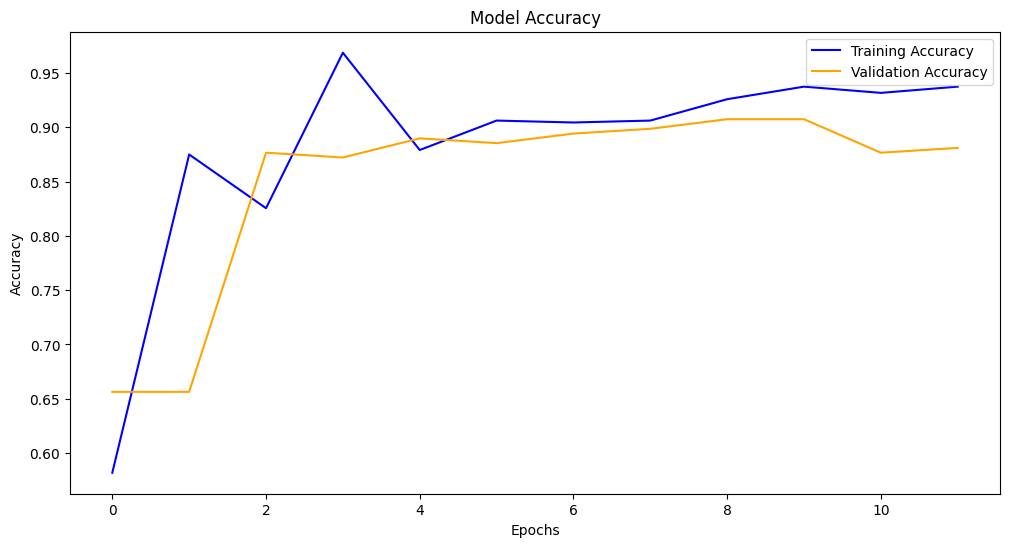

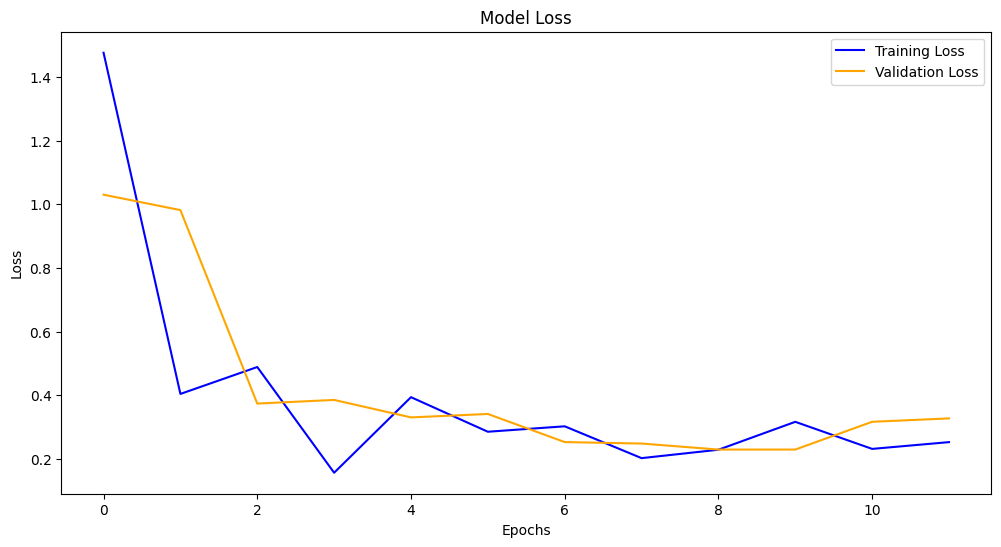

In [1]:
import os
from PIL import Image
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/UCMerced_LandUse/Images'

images = []
categories = []

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            try:
                img = Image.open(file_path).resize((256, 256))
                images.append(np.array(img))
                categories.append(folder)
            except Exception as e:
                print(f"Failed to process {file_path}: {e}")


images = np.array(images, dtype=np.float32) / 255.0

categories = np.array(categories).reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)
encoded_labels = encoder.fit_transform(categories)


X_train, X_temp, y_train, y_temp = train_test_split(images, encoded_labels, test_size=0.3, random_state=42, stratify=categories)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)



datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

unique_categories = sorted(list(set(categories.flatten())))
num_classes = len(unique_categories)

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=12,
    steps_per_epoch=len(X_train) // 32,
    verbose=1
)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

class_report = classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=encoder.categories_[0],
    digits=4
)
print("\nClassification Report:\n")
print(class_report)




plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [2]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,635,247 (17.68 MB)

 Trainable params: 792,079 (3.02 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

 Optimizer params: 1,584,160 (6.04 MB)

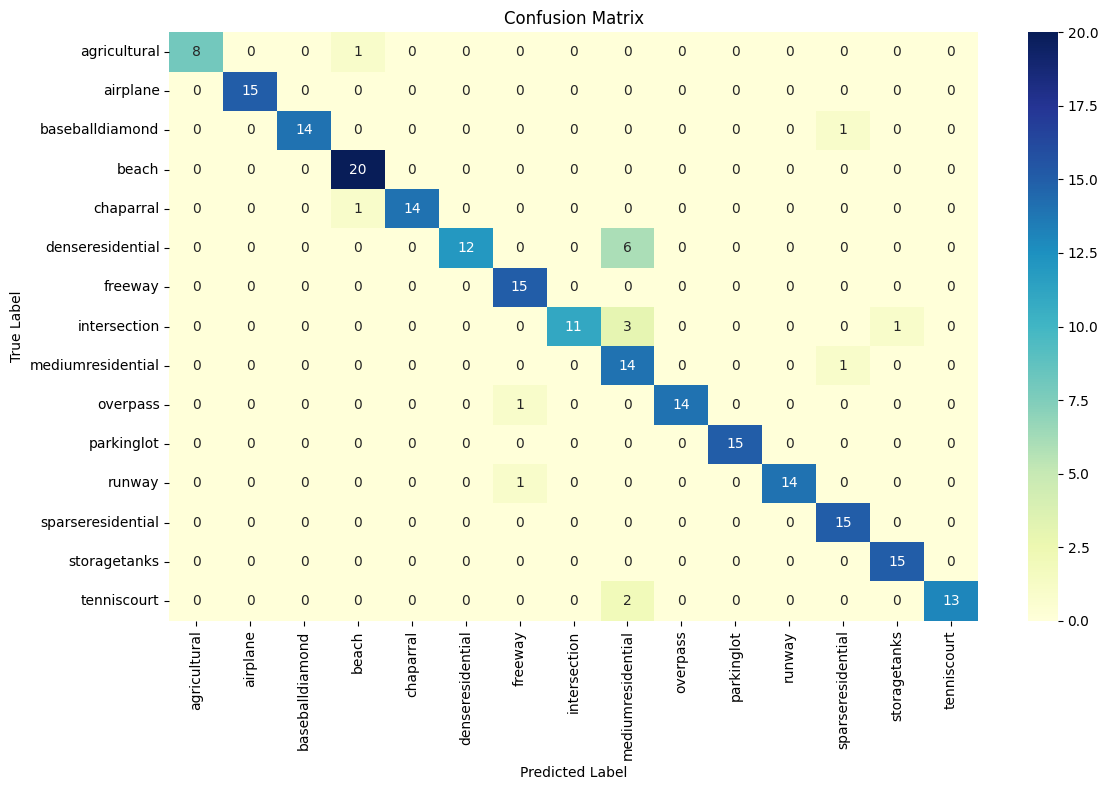

In [3]:
import seaborn as sns

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=True,
            xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks()
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [4]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

print(f"Final Training Accuracy: {train_accuracy[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")
print(f"Final Training Loss: {train_loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Final Training Accuracy: 0.9375
Final Validation Accuracy: 0.8811
Final Training Loss: 0.2524
Final Validation Loss: 0.3270
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9285 - loss: 0.2198
Test Loss: 0.2707
Test Accuracy: 0.9207
